# Name: Nicholas Short

# Assignment: Final Project EfficientDet Model

# Date: 12/2/24

# Class: AAI 521

# EfficientDet Detection

In [12]:
# Import all necessary libraries
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image

Number of bird images: 1302
Number of drone images: 2723


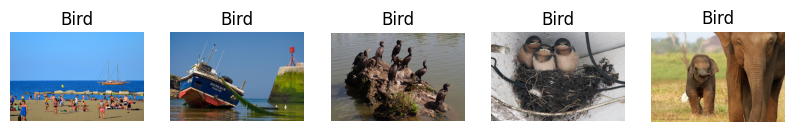

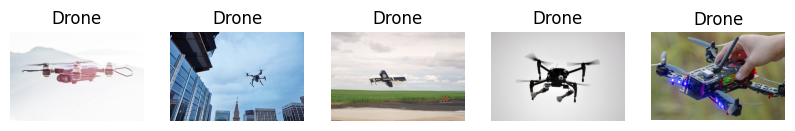

In [13]:
# Dataset paths

birds_dir = "/content/drive/MyDrive/USD AAI /AAI 521/Final Project/images"
drones_dir = "/content/drive/MyDrive/USD AAI /AAI 521/Final Project/dataset_txt"

# Count files in each directory
bird_count = len(os.listdir(birds_dir))
drone_count = len(os.listdir(drones_dir))

print(f"Number of bird images: {bird_count}")
print(f"Number of drone images: {drone_count}")

# Visualize a few images
def visualize_samples(directory, title):
    images = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))] # Filter for image files only
    images = images[:5]
    plt.figure(figsize=(10, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(directory, img_name)
        img = Image.open(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

visualize_samples(birds_dir, "Bird")
visualize_samples(drones_dir, "Drone")

In [15]:
model_url = "https://tfhub.dev/tensorflow/efficientdet/d0/1"  # Use D0 for lightweight; D7 for more power
model = hub.load(model_url)

In [29]:
def load_image(path):
    # Iterate through files in the directory
    for filename in os.listdir(path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for valid image extensions
            img_path = os.path.join(path, filename) # Construct full image path
            img = cv2.imread(img_path) # Read the image file
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img, (512, 512))
                return np.expand_dims(img_resized, axis=0), img
            else:
                print(f"Could not read image: {img_path}")
    # If no valid image was found in the directory
    return None, None

def draw_boxes(image, boxes, class_ids, scores, threshold=0.5):
    for i in range(len(boxes)):
        # Iterate through all scores in the current box's scores array
        score = scores[0][i]
        if score > threshold:
            ymin, xmin, ymax, xmax = boxes[0][i]
            start_point = (int(xmin * image.shape[1]), int(ymin * image.shape[0]))
            end_point = (int(xmax * image.shape[1]), int(ymax * image.shape[0]))
            color = (255, 0, 0)
            cv2.rectangle(image, start_point, end_point, color, 2)
            label = f"Class {class_ids[0][i]}: {score:.2f}"
            cv2.putText(image, label, start_point, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return image

(-0.5, 1279.5, 854.5, -0.5)

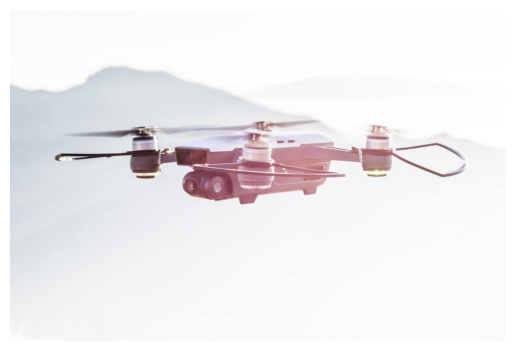

In [33]:
drone_path = "/content/drive/MyDrive/USD AAI /AAI 521/Final Project/dataset_txt"  # Replace with an actual image path
birds_path = "/content/drive/MyDrive/USD AAI /AAI 521/Final Project/images"
input_tensor, original_image = load_image(birds_path)
input_tensor_2, original_image_2 = load_image(drone_path)

# Perform inference
result = model(input_tensor)
result_2 = model(input_tensor_2)

# Extract detections
detections = {key: value.numpy() for key, value in result.items()}
detections_2 = {key: value.numpy() for key, value in result_2.items()}
boxes = detections["detection_boxes"]
boxes_2 = detections_2["detection_boxes"]
class_ids = detections["detection_classes"].astype(int)
class_ids_2 = detections_2["detection_classes"].astype(int)
scores = detections["detection_scores"]
scores_2 = detections_2["detection_scores"]

# Visualize
output_image = draw_boxes(original_image.copy(), boxes, class_ids, scores)
output_image_2 = draw_boxes(original_image_2.copy(), boxes_2, class_ids_2, scores_2)
plt.imshow(output_image_2)
plt.axis('off')
plt.show()

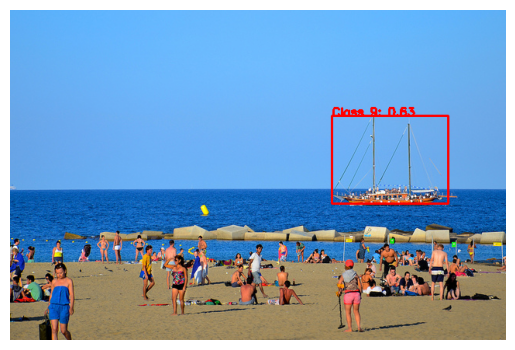

In [35]:
plt.imshow(output_image[3])
plt.axis('off')
plt.show()

# EfficientNet Classification

In [89]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [94]:
# Define the source directory (original dataset)
source_dir = '/content/drive/MyDrive/USD AAI /AAI 521/Final Project/dataset_txt'

# Define the new directories for train and validation
train_dir = '/content/drive/MyDrive/USD AAI /AAI 521/Final Project/train'
val_dir = '/content/drive/MyDrive/USD AAI /AAI 521/Final Project/val'

# Create the folders if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)


In [99]:
# List all files in the source directory
files = os.listdir(source_dir)

# Filter only image files (optional)
image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]


# Split into train and validation sets (80% train, 20% val)
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Move files to respective folders
for file in train_files:
   shutil.move(os.path.join(source_dir, file), os.path.join(train_dir, file))

for file in val_files:
    shutil.move(os.path.join(source_dir, file), os.path.join(val_dir, file))

print("Data successfully split into train and validation sets!")

Data successfully split into train and validation sets!


In [103]:
# Define the source directory
source_dir = '/content/drive/MyDrive/USD AAI /AAI 521/Final Project/val'

# Define class names (adjust as needed)
class_names = ['drone_1', 'drone_2', 'drone_3']

# Create subfolders within the source directory
for class_name in class_names:
    class_folder = os.path.join(source_dir, class_name)
    os.makedirs(class_folder, exist_ok=True)


In [107]:
# List all files in the source directory
files = os.listdir(source_dir)

# Optionally filter files if needed
# files = [f for f in files if f.endswith('.jpg')]

# Example split by class (modify this logic based on your dataset)
class_splits = {
    'drone_1': files[:len(files)//3],
    'drone_2': files[len(files)//3: 2*len(files)//3],
    'drone_3': files[2*len(files)//3:]
}

# Move files into corresponding subfolders
for class_name, file_list in class_splits.items():
   for file in file_list:
        src_file = os.path.join(source_dir, file)
        dst_file = os.path.join(source_dir, class_name, file)
        shutil.move(src_file, dst_file)

print("Files successfully organized into subfolders!")


Files successfully organized into subfolders!


In [108]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
import os

# Set dataset paths (adjust based on your dataset structure in Kaggle)
train_dir = '/content/drive/MyDrive/USD AAI /AAI 521/Final Project/train'
test_dir = '/content/drive/MyDrive/USD AAI /AAI 521/Final Project/val'

# Define image dimensions
img_size = (224, 224)  # EfficientNet typically uses 224x224 input size

# Set up ImageDataGenerators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'  # Assuming multi-class classification
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)




Found 1088 images belonging to 1 classes.
Found 273 images belonging to 1 classes.


In [109]:
# Load pre-trained EfficientNetB0 model without the top layer (to add our custom layers)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Create the custom model on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_generator.num_classes, activation='softmax')  # Output layer with number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [110]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # You can adjust this
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored

34/34 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 186s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 514ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 9/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/st

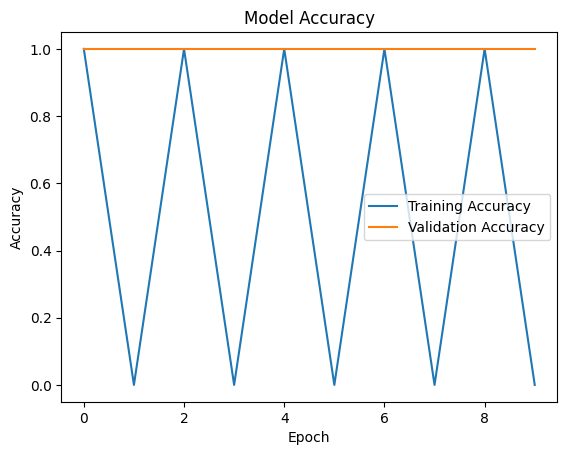

In [111]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

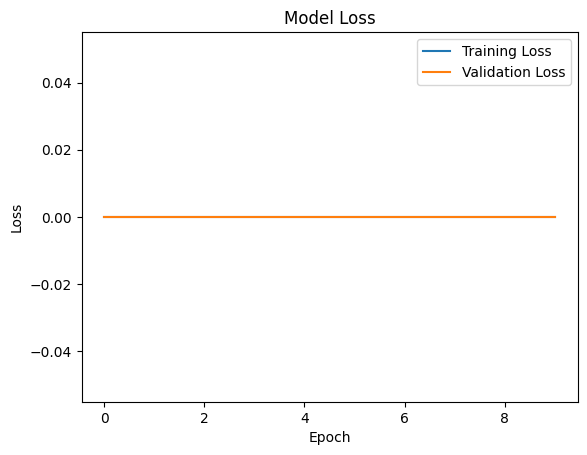

In [112]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [116]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision'])  # Add precision here

In [119]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print(f"Final Training Accuracy: {train_acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")

Final Training Accuracy: 0.0000
Final Validation Accuracy: 1.0000


In [120]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

print(f"Final Training Loss: {train_loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")

Final Training Loss: 0.0000
Final Validation Loss: 0.0000
